### Import dependencies

In [1]:
import os 
import sys 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib 
import matplotlib.pyplot as plt 
import xpressplot as xp

sns.set(font='arial')
jakes_cmap = sns.diverging_palette(212, 61, s=99, l=77, sep=1, n=16, center='dark') #Custom aesthetics

%matplotlib inline

### Read in source files

In [2]:
rna_source_url = os.path.join (os.getcwd(), "..", "data", "mct1_rnaseq_data")  

rnaseq_url = os.path.join (rna_source_url, "sce_mct1_deduped_counts_count_table.tsv")
rnaseq_metadata_url = os.path.join (rna_source_url, "sce_mct1_metadata_copy.txt")

                               
proteomics_source_url = os.path.join (os.getcwd(), "..", "data", "mct1_proteomics_data")                       
proteomics_url = os.path.join (proteomics_source_url, "proteomics_values.txt")


genelist_source_url = os.path.join (os.getcwd(), "..", "data", "analysis_lists")  
aa_genelist_url = os.path.join (genelist_source_url, "aa_gene_list.csv")
nt_genelist_url = os.path.join (genelist_source_url, "GO_0009117_SCE_nucleotide_metabolism.txt")
rna_lengths_url = os.path.join (genelist_source_url, "sce_lengths.txt")


plots_url = os.path.join (os.getcwd(), "..", "plots")  

In [3]:
rnaseq = pd.read_csv(
    rnaseq_url,
    sep="\t",
    index_col=0)
rna_metadata = pd.read_csv(
    rnaseq_metadata_url,
    sep="\t")
rna_lengths = pd.read_csv(
    rna_lengths_url,
    sep="\t",
    index_col=0)
rna_lengths.index.name = None
aa_genes = pd.read_csv(
    aa_genelist_url,
    sep=",")
nt_genes = pd.read_csv(
    nt_genelist_url,
    sep="\t",
    header=None)

proteomics = pd.read_csv(
    proteomics_url,
    sep="\t",
    index_col=0)

### Prepare reference items

In [4]:
rna_length_dict = rna_lengths.to_dict()['Length']

### TPM normalization
1) Divide the read counts by the length of each gene in kilobases. This gives you reads per kilobase (RPK).   
2) Count up all the RPK values in a sample and divide this number by 1,000,000. This is your “per million” scaling factor.   
3) Divide the RPK values by the “per million” scaling factor. This gives you TPM.   
Source: https://rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/

In [5]:
rnaseq_tpm = rnaseq.copy()

print("Initial dataframe size: " + str(rnaseq_tpm.shape))

# remove RNAs with less than 50 counts
rnaseq_tpm = rnaseq_tpm[rnaseq_tpm.min(axis=1) > 25]
print("Count thresholding: " + str(rnaseq_tpm.shape))

# remove RNAs with unmapped lengths -- most are dubious ORFs, ncRNAs, etc.
rnaseq_tpm['lengths'] = rnaseq_tpm.index.map(rna_length_dict)
rnaseq_tpm = rnaseq_tpm[~rnaseq_tpm['lengths'].isna()]
rnaseq_tpm['lengths'] = rnaseq_tpm['lengths'] / 1000
print("Remove misc. RNAs: " + str(rnaseq_tpm.shape))

# Step 1
rnaseq_tpm = rnaseq_tpm.divide((rnaseq_tpm['lengths']), axis=0) 
rnaseq_tpm.drop('lengths', axis=1, inplace=True)

# Step 2
rnaseq_tpm.loc['per_million'] = rnaseq_tpm.sum(axis=0) / 1000000

# Step 3
rnaseq_tpm = rnaseq_tpm.divide((rnaseq_tpm.loc['per_million']), axis=1) 
rnaseq_tpm.drop('per_million', axis=0, inplace=True)

# Check outputs 
print("\nCheck outputs:")
print(rnaseq_tpm.sum())

Initial dataframe size: (7127, 24)
Count thresholding: (5643, 24)
Remove misc. RNAs: (5450, 25)

Check outputs:
14251X1     1000000.0
14251X2     1000000.0
14251X3     1000000.0
14251X4     1000000.0
14251X5     1000000.0
14251X6     1000000.0
14251X7     1000000.0
14251X8     1000000.0
14251X9     1000000.0
14251X10    1000000.0
14251X11    1000000.0
14251X12    1000000.0
14251X13    1000000.0
14251X14    1000000.0
14251X15    1000000.0
14251X16    1000000.0
14251X17    1000000.0
14251X18    1000000.0
14251X19    1000000.0
14251X20    1000000.0
14251X21    1000000.0
14251X22    1000000.0
14251X23    1000000.0
14251X24    1000000.0
dtype: float64


In [6]:
rnaseq_tpm.to_csv(
    os.path.join(rna_source_url, "sce_mct1_deduped_tpm_threshold25.tsv"),
    sep='\t')

### Get gene set dataframe

In [7]:
# AA metabolism
rnaseq_aaSet = rnaseq_tpm.reindex(aa_genes['gene_id'].tolist()).dropna(axis=0)

# Rename gene IDs to gene names
gene_name_dict = aa_genes.set_index('gene_id').to_dict()['gene_name']
gene_class_dict = aa_genes.set_index('gene_name').to_dict()['function']
rnaseq_aaSet = rnaseq_aaSet.rename(index=gene_name_dict)

# nt metabolism 
rnaseq_ntSet = rnaseq_tpm.reindex(list(set(nt_genes[1].tolist()))).dropna(axis=0)

### Plot data

In [8]:
# Sort data by condition params
rna_metadata = rna_metadata.sort_values(["Condition", "Time"], ascending = (True, True))
rnaseq_aaSet = rnaseq_aaSet[rna_metadata.Sample.tolist()]

# Set labels and set color-codes for rows
gene_hex = {
    'Amino acid anabolism':'#1b9e77', 
    'Amino acid catabolism':'#d95f02'}

gene_colors = rnaseq_aaSet.copy()
gene_colors['labels'] = gene_colors.index.map(gene_class_dict)
gene_colors = gene_colors[['labels']]
gene_colors['labels'] = gene_colors['labels'].map(gene_hex)

In [9]:
# Set labels and set color-codes for cols
condition_hex = {
    'WT':'#AAAAAA', 
    'mct1':'#464646'}
time_hex = {
    0:'#a2cffe',
    3:'#047495',
    12:'#1f3b4d'}

col_colors = rna_metadata.set_index('Sample').copy()
col_colors.index.name = None

col_colors['Condition'] = col_colors['Condition'].map(condition_hex)
col_colors['Time'] = col_colors['Time'].map(time_hex)

col_colors1 = col_colors.copy()[['Condition']]
col_colors1.columns = ['label']
col_colors2 = col_colors.copy()[['Time']]
col_colors2.columns = ['label']

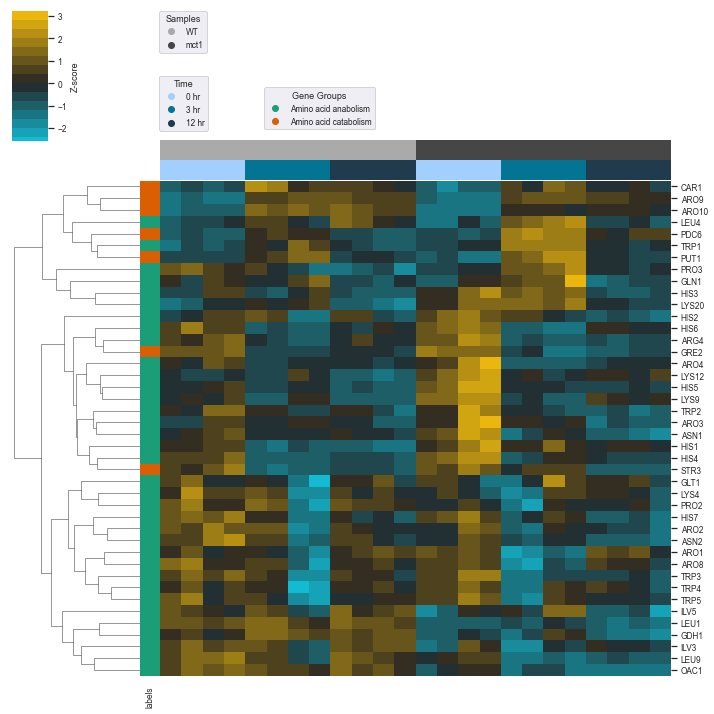

In [10]:
sns.set(font_scale=0.75)
sns.clustermap(
    rnaseq_aaSet,
    z_score=0,
    xticklabels=False,
    row_cluster=True,
    col_cluster=False,
    center=0,
    cbar_kws={'label': 'Z-score'},
    row_colors=gene_colors,
    col_colors=[col_colors1.label, col_colors2.label],
    cmap=jakes_cmap)

# Label legends
f = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [f("s", list(gene_hex.values())[i]) for i in range(len(list(gene_hex.values())))]
first_legend = plt.legend(handles, list(gene_hex.keys()), bbox_to_anchor=(7, 0.41), loc=2, borderaxespad=0., title='Gene Groups')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

ff = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [ff("s", list(time_hex.values())[i]) for i in range(len(list(time_hex.values())))]
second_legend = plt.legend(handles, [str(x) + " hr" for x in list(time_hex.keys())], bbox_to_anchor=(4.1, 0.5), loc=2, borderaxespad=0., title='Time')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(second_legend)

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(condition_hex.values())[i]) for i in range(len(list(condition_hex.values())))]
plt.legend(handles_g, list(condition_hex.keys()), bbox_to_anchor=(4.1, 1), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(plots_url, "aa_gene_list_rnaseq.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

In [11]:
# AA metabolism
proteomics_aa = proteomics.reindex(aa_genes['gene_name'].tolist()).dropna(axis=0)

# nt metabolism 
proteomics_nt = proteomics.reindex(list(set(nt_genes[1].tolist()))).dropna(axis=0)

In [12]:
protein_colors = proteomics_aa.copy()
protein_colors['labels'] = protein_colors.index.map(gene_class_dict)
protein_colors = protein_colors[['labels']]
protein_colors['labels'] = protein_colors['labels'].map(gene_hex)

In [13]:
sample_hex = {
    'WT_1':'#AAAAAA', 
    'WT_2':'#AAAAAA',
    'WT_3':'#AAAAAA',
    'mct1_1':'#464646',
    'mct1_2':'#464646',
    'mct1_3':'#464646'}

proteomics_labels = proteomics_aa.T.copy()
proteomics_labels['label'] = proteomics_labels.index.map(sample_hex)
proteomics_labels = proteomics_labels[['label']]

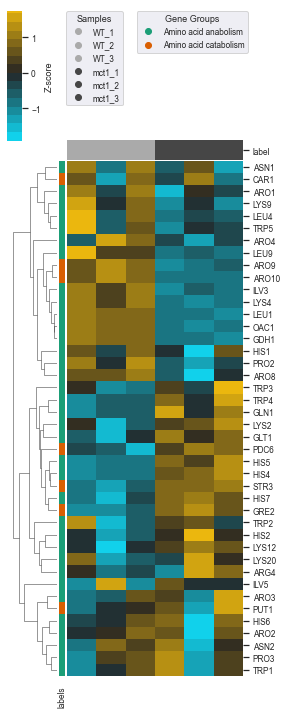

In [14]:
sns.set(font_scale=0.75)
sns.clustermap(
    proteomics_aa,
    z_score=0,
    xticklabels=False,
    row_cluster=True,
    col_cluster=False,
    center=0,
    cbar_kws={'label': 'Z-score'},
    row_colors=protein_colors,
    col_colors=proteomics_labels,
    figsize=(4,10),
    cmap=jakes_cmap)

# Label legends
f = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [f("s", list(gene_hex.values())[i]) for i in range(len(list(gene_hex.values())))]
first_legend = plt.legend(handles, list(gene_hex.keys()), bbox_to_anchor=(9, 1), loc=2, borderaxespad=0., title='Gene Groups')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(sample_hex.values())[i]) for i in range(len(list(sample_hex.values())))]
plt.legend(handles_g, list(sample_hex.keys()), bbox_to_anchor=(4.1, 1), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(plots_url, "aa_gene_list_protein.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

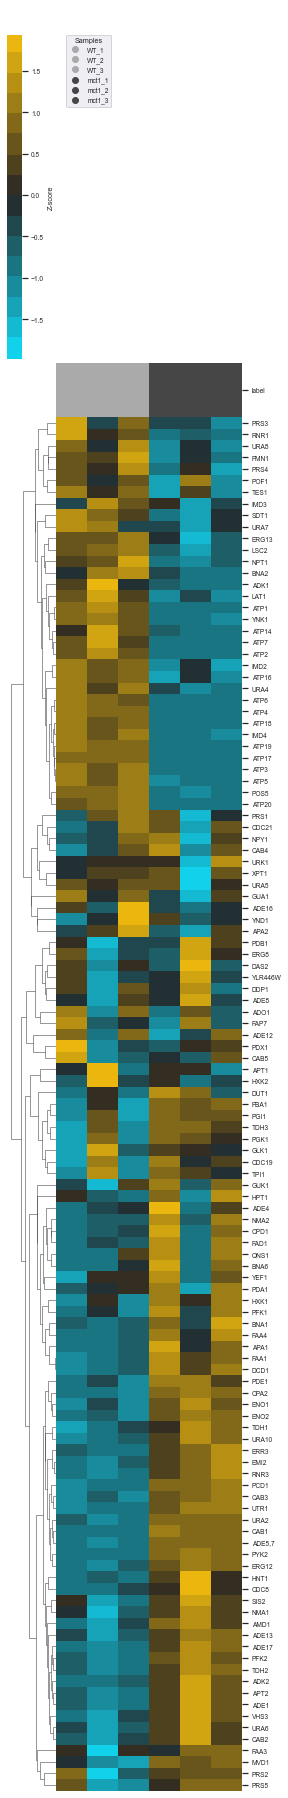

In [15]:
sns.set(font_scale=0.6)
sns.clustermap(
    proteomics_nt,
    z_score=0,
    xticklabels=False,
    row_cluster=True,
    col_cluster=False,
    center=0,
    cbar_kws={'label': 'Z-score'},
    col_colors=proteomics_labels,
    figsize=(4,25),
    cmap=jakes_cmap)

# Label legends
g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(sample_hex.values())[i]) for i in range(len(list(sample_hex.values())))]
plt.legend(handles_g, list(sample_hex.keys()), bbox_to_anchor=(4.1, 1), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(plots_url, "nt_gene_list_protein.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

In [16]:
# AA metabolism
proteomics_aa = proteomics.reindex(aa_genes['gene_name'].tolist()).dropna(axis=0)

# nt metabolism 
proteomics_nt = proteomics.reindex(list(set(nt_genes[1].tolist()))).dropna(axis=0)

# Glyoxylate cycle

In [17]:
glyoxylate_url = os.path.join (genelist_source_url, "glyoxylate-cycle-pathway-genes-sgd.txt")
glyoxylate_genes = pd.read_csv(
    glyoxylate_url,
    sep="\t",
    comment="#")

In [18]:
glyoxylate_genes['Gene name'].tolist()

['MDH3',
 'MDH2',
 'MAE1',
 'CIT2',
 'ACO1',
 'ACO2',
 'ACO1',
 'ACO2',
 'ICL1',
 'MLS1',
 'DAL7',
 'CTP1',
 'SFC1']

In [19]:
proteomics_glyoxylate = proteomics.reindex(list(set(glyoxylate_genes['Gene name'].tolist()))).dropna(axis=0)

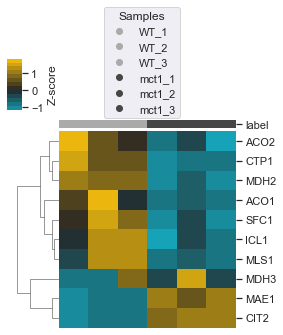

In [20]:
sns.set(font_scale=1)
sns.clustermap(
    proteomics_glyoxylate,
    z_score=0,
    xticklabels=False,
    row_cluster=True,
    col_cluster=False,
    center=0,
    cbar_kws={'label': 'Z-score'},
    col_colors=proteomics_labels,
    figsize=(4,4),
    cmap=jakes_cmap)

# Label legends
g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(sample_hex.values())[i]) for i in range(len(list(sample_hex.values())))]
plt.legend(handles_g, list(sample_hex.keys()), bbox_to_anchor=(6.7, 2), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(plots_url, "glyoxylate_gene_list_protein.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

CIT2: Citrate synthase, peroxisomal isozyme involved in glyoxylate cycle; catalyzes condensation of acetyl coenzyme A and oxaloacetate to form citrate; expression is controlled by Rtg1p and Rtg2p transcription factors; SCF-Ucc1 regulates level of Cit2p to maintain citrate homeostasis; oxaloacetate-dependent positive feedback loop inhibits Cit2p ubiquitination; CIT2 has a paralog, CIT1, that arose from the whole genome duplication

In [21]:
tca_proteins = [
    "PYC1",
    "PYC2",
    "MPC1",
    "MPC2",
    "MPC3",
    "CIT3",
    "CIT1",
    "ACO1",
    "ACO2",
    "IDH1",
    "IDH2",
    "LPD1",
    "KGD1",
    "KGD2",
    "LSC1",
    "LSC2",
    "SDH4",
    "SDH3",
    "SDH2",
    "YJL045W",
    "SDH1",
    "FUM1",
    "MAE1",
    "MDH1",
    "GDH1",
    "GDH2",
    
]
proteomics_tca = proteomics.reindex(tca_proteins).dropna(axis=0)

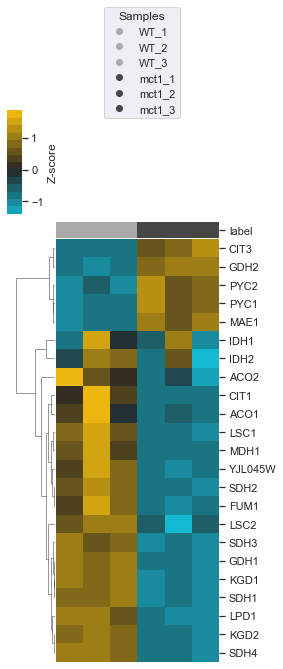

In [22]:
sns.set(font_scale=1)
sns.clustermap(
    proteomics_tca,
    z_score=0,
    xticklabels=False,
    row_cluster=True,
    col_cluster=False,
    center=0,
    cbar_kws={'label': 'Z-score'},
    col_colors=proteomics_labels,
    figsize=(4,8),
    cmap=jakes_cmap)

# Label legends
g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(sample_hex.values())[i]) for i in range(len(list(sample_hex.values())))]
plt.legend(handles_g, list(sample_hex.keys()), bbox_to_anchor=(6.7, 2), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(plots_url, "tca_gene_list_protein.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

In [23]:
final_proteins = [
    "PYC1",
    "PYC2",
    "MAE1",
    "GDH1",
    "GDH2",
    
]
proteomics_final = proteomics.reindex(final_proteins).dropna(axis=0)

sample_hex_mod = {
    'WT': '#AAAAAA',
    'mct1': '#464646',
}

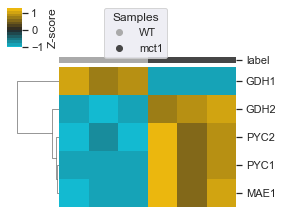

In [24]:
sns.set(font_scale=1)
sns.clustermap(
    proteomics_final,
    z_score=0,
    xticklabels=False,
    row_cluster=True,
    col_cluster=False,
    center=0,
    cbar_kws={'label': 'Z-score'},
    col_colors=proteomics_labels,
    figsize=(4,3),
    cmap=jakes_cmap)

# Label legends
g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(sample_hex_mod.values())[i]) for i in range(len(list(sample_hex_mod.values())))]
plt.legend(handles_g, list(sample_hex_mod.keys()), bbox_to_anchor=(6.7, 1), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(plots_url, "final_gene_list_protein.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

In [25]:
final_proteins = [
    "MAE1",
    "PYC1",
    "PYC2",
    "CIT1",
    "CIT2",
    "CIT3",
    "ACO1",
    "ACO2",
    "IDH1",
    "IDH2",
    "GDH1",
    "GDH2"
    
]
proteomics_final = proteomics.reindex(final_proteins).dropna(axis=0)

sample_hex_mod = {
    'WT': '#AAAAAA',
    'mct1': '#464646',
}

In [26]:
proteomics_final[::-1]

,WT_1,WT_2,WT_3,mct1_1,mct1_2,mct1_3
GDH2,5.022820,4.671230,5.142670,8.96851,9.55053,9.89657
GDH1,22.864600,19.641100,21.921400,3.77899,3.88050,3.08858
IDH2,10.390000,12.425100,11.824600,9.52887,11.63890,8.77095
IDH1,9.280660,11.720400,10.054700,9.33028,11.19420,8.93955
ACO2,8.487270,7.395370,7.092470,6.18737,6.66719,5.80946
ACO1,10.946700,13.940800,10.443500,8.98799,9.64408,9.08089
CIT3,1.225360,1.181200,1.216730,3.73960,4.15533,4.76334
CIT2,0.599546,0.823996,0.971257,7.06537,7.92993,7.90818
CIT1,8.206470,15.382400,8.891030,3.96649,4.15441,3.71538
PYC2,5.789140,6.876980,5.881210,12.39120,10.68450,11.57670


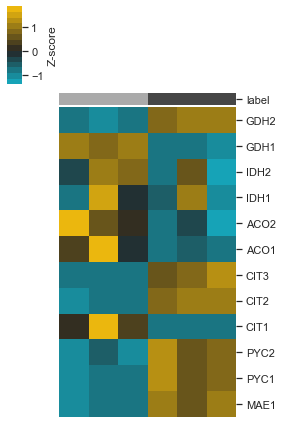

In [27]:
sns.set(font_scale=1)
sns.clustermap(
    proteomics_final[::-1],
    z_score=0,
    xticklabels=False,
    row_cluster=False,
    col_cluster=False,
    center=0,
    cbar_kws={'label': 'Z-score'},
    col_colors=proteomics_labels,
    figsize=(4,6),
    cmap=jakes_cmap)

# Label legends
#g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
#handles_g = [f("s", list(sample_hex_mod.values())[i]) for i in range(len(list(sample_hex_mod.values())))]
#plt.legend(handles_g, list(sample_hex_mod.keys()), bbox_to_anchor=(6.7, 1), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(plots_url, "final_gene_list_protein.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

In [28]:
for x in proteomics.index.tolist():
    if "lst" in x.lower():
        print(x)

LST8
LST7
LST4


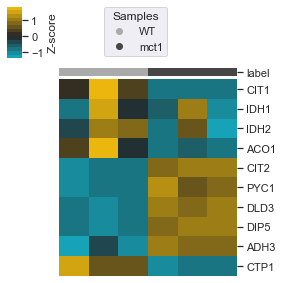

In [29]:
rtg_proteins = [
    'CIT1', 'IDH1', 'IDH2', 'ACO1', 'CIT2', 'PYC1', 'DLD3', 'DIP5', 'ADH3', #target
    'CTP1' #ctp
    
]
proteomics_rtg = proteomics.reindex(rtg_proteins).dropna(axis=0)

sample_hex_mod = {
    'WT': '#AAAAAA',
    'mct1': '#464646',
}

sns.set(font_scale=1)
sns.clustermap(
    proteomics_rtg,
    z_score=0,
    xticklabels=False,
    row_cluster=False,
    col_cluster=False,
    center=0,
    cbar_kws={'label': 'Z-score'},
    col_colors=proteomics_labels,
    figsize=(4,4),
    cmap=jakes_cmap)

# Label legends
g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(sample_hex_mod.values())[i]) for i in range(len(list(sample_hex_mod.values())))]
plt.legend(handles_g, list(sample_hex_mod.keys()), bbox_to_anchor=(6.7, 1), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(plots_url, "rtg_gene_list_protein.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

In [30]:
for x in proteomics.index.tolist():
    if 'lys' in x.lower():
        print(x)

LYS4
LYS14
LYS9
LYS2
LYS12
LYS21
LYS1
LYS20


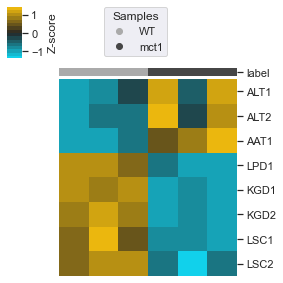

In [31]:
rtg_proteins = [
    'ALT1', 'ALT2', 'AAT1',
    'LPD1', 'KGD1', 'KGD2', 'LSC1', 'LSC2'
    
]
proteomics_rtg = proteomics.reindex(rtg_proteins).dropna(axis=0)

sample_hex_mod = {
    'WT': '#AAAAAA',
    'mct1': '#464646',
}

sns.set(font_scale=1)
sns.clustermap(
    proteomics_rtg,
    z_score=0,
    xticklabels=False,
    row_cluster=False,
    col_cluster=False,
    center=0,
    cbar_kws={'label': 'Z-score'},
    col_colors=proteomics_labels,
    figsize=(4,4),
    cmap=jakes_cmap)

# Label legends
g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(sample_hex_mod.values())[i]) for i in range(len(list(sample_hex_mod.values())))]
plt.legend(handles_g, list(sample_hex_mod.keys()), bbox_to_anchor=(6.7, 1), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(plots_url, "aa_other_gene_list_protein.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

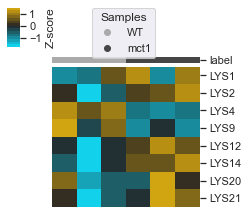

In [32]:
rtg_proteins = [
    'LYS1',
    'LYS2',
    'LYS4', 
    'LYS9',
    'LYS12',
    'LYS14',
    'LYS20',
    'LYS21'
]
proteomics_rtg = proteomics.reindex(rtg_proteins).dropna(axis=0)

sample_hex_mod = {
    'WT': '#AAAAAA',
    'mct1': '#464646',
}

sns.set(font_scale=1)
sns.clustermap(
    proteomics_rtg,
    z_score=0,
    xticklabels=False,
    row_cluster=False,
    col_cluster=False,
    center=0,
    cbar_kws={'label': 'Z-score'},
    col_colors=proteomics_labels,
    figsize=(3.5,3),
    cmap=jakes_cmap)

# Label legends
g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(sample_hex_mod.values())[i]) for i in range(len(list(sample_hex_mod.values())))]
plt.legend(handles_g, list(sample_hex_mod.keys()), bbox_to_anchor=(6.7, 1), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(plots_url, "lys_gene_list_protein.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

MDH1: catalyzes interconversion of malate and oxaloacetate    
MAE1: catalyzes the oxidative decarboxylation of malate to pyruvate
    
CIT1: catalyzes condensation of acetyl coenzyme A and oxaloacetate to form citrate    
CIT3: Dual specificity mitochondrial citrate and methylcitrate synthase; 
    catalyzes the condensation of acetyl-CoA and oxaloacetate to form citrate 
    and that of propionyl-CoA and oxaloacetate to form 2-methylcitrate

# Metabolomics

In [33]:
mct1_metabolomics_source_url = os.path.join (os.getcwd(), "..", "data", "mct1_metabolomics_data")  

mct1_url = os.path.join (mct1_metabolomics_source_url, "mct1_metabolomics_allValues.txt")
mct1_metadata_url = os.path.join (mct1_metabolomics_source_url, "mct1_metabolomics_metadata.txt")

metabolite_url = os.path.join (genelist_source_url, "metabolite_list.txt")

In [34]:
mct1_metabolomics = pd.read_csv(
    mct1_url,
    sep="\t",
    index_col=0)
mct1_metadata = pd.read_csv(
    mct1_metadata_url,
    sep="\t",
    index_col=0)

metabolite_list = pd.read_csv(
    metabolite_url,
    sep="\t",
    index_col=0)

In [35]:
# Sort data by condition params
metabolomics_mct1Set = mct1_metabolomics.copy()
metabolomics_mct1Set = metabolomics_mct1Set.reindex(metabolite_list.index.tolist(), axis=0)

In [36]:
# Set labels and set color-codes for rows
metabolite_hex = {
    'amino acid':'#1b9e77', 
    'nucleotides':'#d95f02'}

metabolite_colors = metabolite_list.copy()
metabolite_colors['label'] = metabolite_colors['label'].map(metabolite_hex)

In [37]:
# Sort data by condition params
mct1_metadata = mct1_metadata.sort_values(["Condition", "Time"], ascending = (True, True))
metabolomics_mct1Set = metabolomics_mct1Set[mct1_metadata.index.tolist()]

In [38]:
# Set labels and set color-codes for cols
mct1_condition_hex = {
    'WT':'#AAAAAA', 
    'mct1':'#464646'}
mct1_time_hex = {
    '000min':'#a2cffe',
    '015min':'#047495',
    '030min':'#1f3b4d',
    '060min':'#152238',
    '180min':'#000000'}

mct1_colors = mct1_metadata.copy()

mct1_colors['Condition'] = mct1_colors['Condition'].map(mct1_condition_hex)
mct1_colors['Time'] = mct1_colors['Time'].map(mct1_time_hex)

mct1_colors1 = mct1_colors.copy()[['Condition']]
mct1_colors1.columns = ['label']
mct1_colors2 = mct1_colors.copy()[['Time']]
mct1_colors2.columns = ['label']

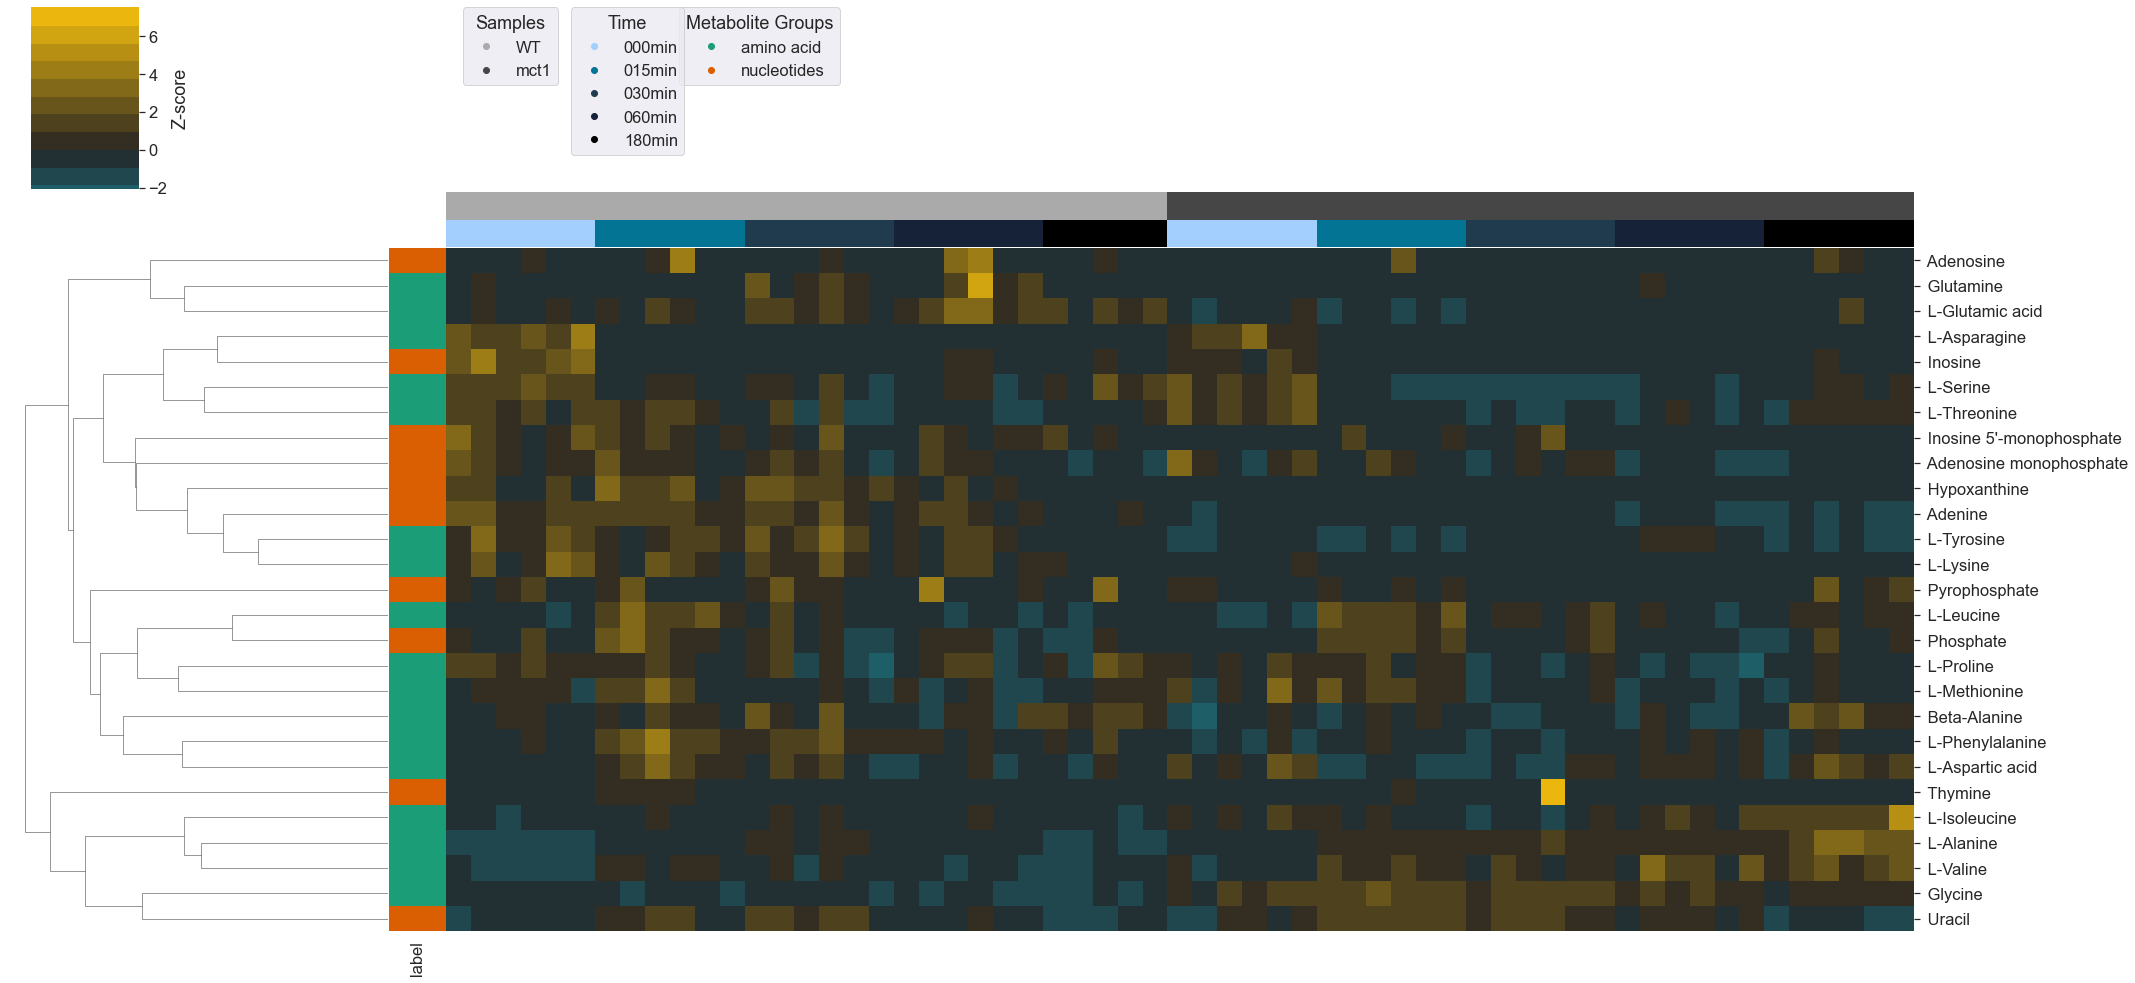

In [39]:
sns.set(font_scale=1.5)
sns.clustermap(
    metabolomics_mct1Set,
    z_score=0,
    xticklabels=False,
    row_cluster=True,
    col_cluster=False,
    center=0,
    figsize=(30,14),
    cbar_kws={'label': 'Z-score'},
    row_colors=metabolite_colors,
    col_colors=[mct1_colors1.label, mct1_colors2.label],
    cmap=jakes_cmap)

# Label legends
f = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [f("s", list(metabolite_hex.values())[i]) for i in range(len(list(metabolite_hex.values())))]
first_legend = plt.legend(handles, list(metabolite_hex.keys()), bbox_to_anchor=(6, 1), loc=2, borderaxespad=0., title='Metabolite Groups')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

ff = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [ff("s", list(mct1_time_hex.values())[i]) for i in range(len(list(mct1_time_hex.values())))]
second_legend = plt.legend(handles, list(mct1_time_hex.keys()), bbox_to_anchor=(5, 1), loc=2, borderaxespad=0., title='Time')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(second_legend)

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(mct1_condition_hex.values())[i]) for i in range(len(list(mct1_condition_hex.values())))]
plt.legend(handles_g, list(mct1_condition_hex.keys()), bbox_to_anchor=(4, 1), loc=2, borderaxespad=0., title='Samples')


#Save and show figure
plt.savefig(
    os.path.join(plots_url, "aa_nt_list_mct1_metabolomics.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

In [40]:
metabolomics_mct1Set2 = mct1_metabolomics.copy()
metabolomics_mct1Set2 = metabolomics_mct1Set2.reindex(
    metabolite_list[metabolite_list['label'] == 'amino acid'].index.tolist(), 
    axis=0)
metabolomics_mct1Set2 = metabolomics_mct1Set2[mct1_metadata.index.tolist()]

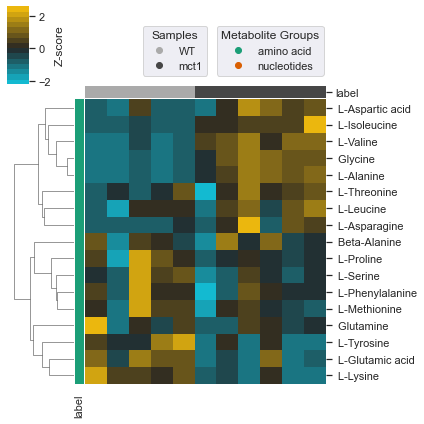

In [41]:
sns.set(font_scale=1)
sns.clustermap(
    metabolomics_mct1Set2[[
         'WT at 3hr minR+Leu 1',
         'WT at 3hr minR+Leu 2',
         'WT at 3hr minR+Leu 3',
         'WT at 3hr minR+Leu 4',
         'WT at 3hr minR+Leu 5',
         'mct1KO at 3hr minR+Leu 1',
         'mct1KO at 3hr minR+Leu 2',
         'mct1KO at 3hr minR+Leu 3',
         'mct1KO at 3hr minR+Leu 4',
         'mct1KO at 3hr minR+Leu 5',
         'mct1KO at 3hr minR+Leu 6'
    ]],
    z_score=0,
    xticklabels=False,
    row_cluster=True,
    col_cluster=False,
    center=0,
    figsize=(6,6),
    cbar_kws={'label': 'Z-score'},
    row_colors=metabolite_colors,
    col_colors=mct1_colors1,
    cmap=jakes_cmap)

# Label legends
f = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [f("s", list(metabolite_hex.values())[i]) for i in range(len(list(metabolite_hex.values())))]
first_legend = plt.legend(handles, list(metabolite_hex.keys()), bbox_to_anchor=(9.7, 0.75), loc=2, borderaxespad=0., title='Metabolite Groups')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(mct1_condition_hex.values())[i]) for i in range(len(list(mct1_condition_hex.values())))]
plt.legend(handles_g, list(mct1_condition_hex.keys()), bbox_to_anchor=(6.3, 0.75), loc=2, borderaxespad=0., title='Samples')


#Save and show figure
plt.savefig(
    os.path.join(plots_url, "aa_list_mct1_metabolomics_3hr.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

In [42]:
glyoxylate_metabolites = [
    ' Citric acid ',
    ' cis-Aconitic acid',
    ' Isocitric acid ',
    ' Succinic acid ',
    " Glyoxylic acid ",
    ' D-Malic acid ',
]

In [43]:
metabolomics_mct1_glyoxylate = mct1_metabolomics.copy()
metabolomics_mct1_glyoxylate = metabolomics_mct1_glyoxylate.reindex(glyoxylate_metabolites, axis=0)

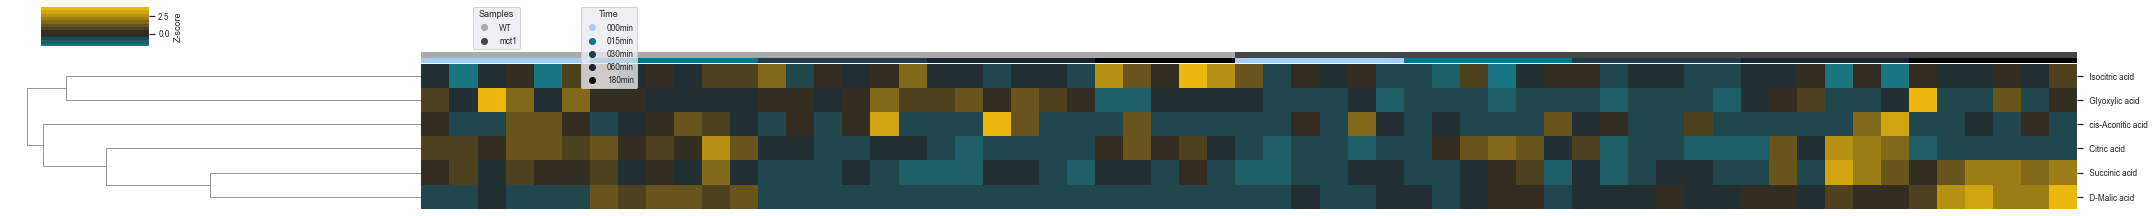

In [44]:
sns.set(font_scale=0.75)
sns.clustermap(
    metabolomics_mct1_glyoxylate,
    z_score=0,
    xticklabels=False,
    row_cluster=True,
    col_cluster=False,
    center=0,
    figsize=(30,3),
    cbar_kws={'label': 'Z-score'},
    col_colors=[mct1_colors1.label, mct1_colors2.label],
    cmap=jakes_cmap)

# Label legends

ff = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [ff("s", list(mct1_time_hex.values())[i]) for i in range(len(list(mct1_time_hex.values())))]
second_legend = plt.legend(handles, list(mct1_time_hex.keys()), bbox_to_anchor=(5, 1), loc=2, borderaxespad=0., title='Time')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(second_legend)

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(mct1_condition_hex.values())[i]) for i in range(len(list(mct1_condition_hex.values())))]
plt.legend(handles_g, list(mct1_condition_hex.keys()), bbox_to_anchor=(4, 1), loc=2, borderaxespad=0., title='Samples')


#Save and show figure
plt.savefig(
    os.path.join(plots_url, "glyoxylatet_mct1_metabolomics.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

In [45]:
tca_metabolites = [
    ' Pyruvic acid ',
    ' Citric acid ',
    ' cis-Aconitic acid',
    ' Isocitric acid ',
    ' Succinic acid ',
    ' Fumaric acid ',
    ' D-Malic acid ',
    ' Glutamic acid ',
    ' L-Glutamic acid'
    
]

In [46]:
metabolomics_mct1_tca = mct1_metabolomics.copy()
metabolomics_mct1_tca = metabolomics_mct1_tca.reindex(tca_metabolites, axis=0)

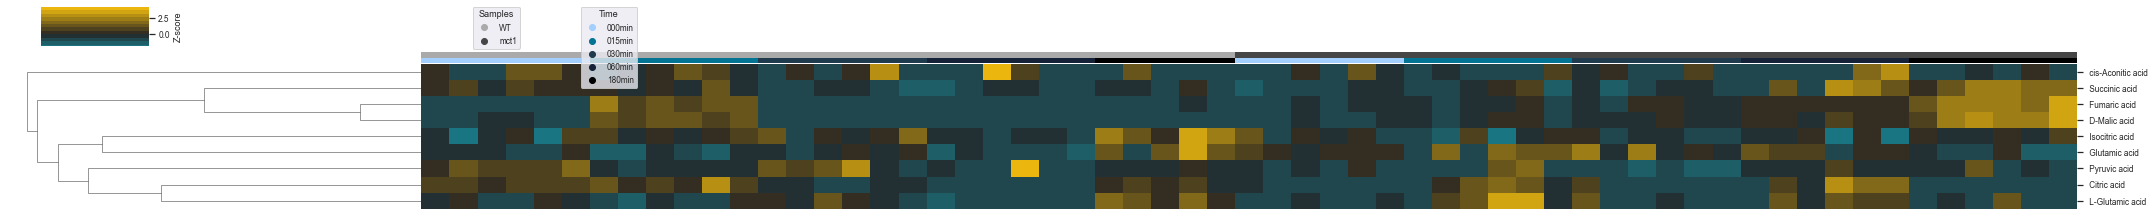

In [47]:
sns.set(font_scale=0.75)
sns.clustermap(
    metabolomics_mct1_tca,
    z_score=0,
    xticklabels=False,
    row_cluster=True,
    col_cluster=False,
    center=0,
    figsize=(30,3),
    cbar_kws={'label': 'Z-score'},
    col_colors=[mct1_colors1.label, mct1_colors2.label],
    cmap=jakes_cmap)

# Label legends

ff = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [ff("s", list(mct1_time_hex.values())[i]) for i in range(len(list(mct1_time_hex.values())))]
second_legend = plt.legend(handles, list(mct1_time_hex.keys()), bbox_to_anchor=(5, 1), loc=2, borderaxespad=0., title='Time')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(second_legend)

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(mct1_condition_hex.values())[i]) for i in range(len(list(mct1_condition_hex.values())))]
plt.legend(handles_g, list(mct1_condition_hex.keys()), bbox_to_anchor=(4, 1), loc=2, borderaxespad=0., title='Samples')


#Save and show figure
plt.savefig(
    os.path.join(plots_url, "tca_mct1_metabolomics.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

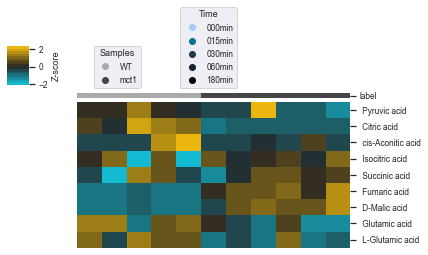

In [48]:
sns.set(font_scale=0.75)
sns.clustermap(
    metabolomics_mct1_tca[[
         'WT at 3hr minR+Leu 1',
         'WT at 3hr minR+Leu 2',
         'WT at 3hr minR+Leu 3',
         'WT at 3hr minR+Leu 4',
         'WT at 3hr minR+Leu 5',
         'mct1KO at 3hr minR+Leu 1',
         'mct1KO at 3hr minR+Leu 2',
         'mct1KO at 3hr minR+Leu 3',
         'mct1KO at 3hr minR+Leu 4',
         'mct1KO at 3hr minR+Leu 5',
         'mct1KO at 3hr minR+Leu 6'
    ]],
    z_score=0,
    xticklabels=False,
    row_cluster=False,
    col_cluster=False,
    center=0,
    figsize=(6,3),
    cbar_kws={'label': 'Z-score'},
    col_colors=mct1_colors1,
    cmap=jakes_cmap)

# Label legends

ff = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [ff("s", list(mct1_time_hex.values())[i]) for i in range(len(list(mct1_time_hex.values())))]
second_legend = plt.legend(handles, list(mct1_time_hex.keys()), bbox_to_anchor=(8, 2), loc=2, borderaxespad=0., title='Time')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(second_legend)

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(mct1_condition_hex.values())[i]) for i in range(len(list(mct1_condition_hex.values())))]
plt.legend(handles_g, list(mct1_condition_hex.keys()), bbox_to_anchor=(4, 1), loc=2, borderaxespad=0., title='Samples')


#Save and show figure
plt.savefig(
    os.path.join(plots_url, "tca_mct1_metabolomics_3hr.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

In [49]:
final_mct1_metabolites = [
    ' Pyruvic acid ',
    ' Citric acid ',
    ' cis-Aconitic acid',
    ' Isocitric acid ',
    ' Glutamic acid ',
    ' L-Glutamic acid',
    ' Succinic acid ',
    ' Fumaric acid ',
    ' D-Malic acid ',
]
metabolomics_mct1_final = mct1_metabolomics.copy()
metabolomics_mct1_final = metabolomics_mct1_final.reindex(final_mct1_metabolites, axis=0)

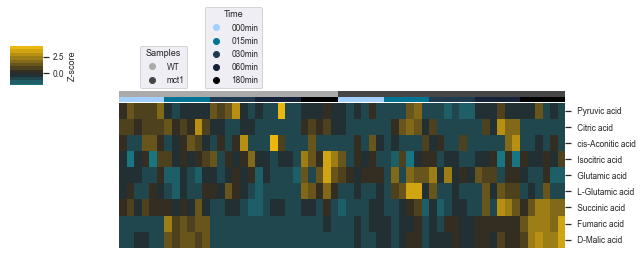

In [50]:
sns.set(font_scale=0.75)
sns.clustermap(
    metabolomics_mct1_final,
    z_score=0,
    xticklabels=False,
    row_cluster=False,
    col_cluster=False,
    center=0,
    figsize=(9,3),
    cbar_kws={'label': 'Z-score'},
    col_colors=[mct1_colors1.label, mct1_colors2.label],
    cmap=jakes_cmap)

# Label legends

ff = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [ff("s", list(mct1_time_hex.values())[i]) for i in range(len(list(mct1_time_hex.values())))]
second_legend = plt.legend(handles, list(mct1_time_hex.keys()), bbox_to_anchor=(6, 2), loc=2, borderaxespad=0., title='Time')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(second_legend)

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(mct1_condition_hex.values())[i]) for i in range(len(list(mct1_condition_hex.values())))]
plt.legend(handles_g, list(mct1_condition_hex.keys()), bbox_to_anchor=(4, 1), loc=2, borderaxespad=0., title='Samples')


#Save and show figure
plt.savefig(
    os.path.join(plots_url, "final_mct1_metabolomics.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

### CTP1 metabolomics

In [51]:
ctp1_metabolomics_source_url = os.path.join (os.getcwd(), "..", "data", "ctp1_metabolomics_data")  

ctp1_url = os.path.join(ctp1_metabolomics_source_url, "ctp1_metabolomics_allValues.txt")
ctp1_metadata_url = os.path.join(ctp1_metabolomics_source_url, "ctp1_metabolomics_metadata.txt")

ctp1_metabolite_url = os.path.join(genelist_source_url, "ctp1_metabolite_list.txt")

In [52]:
ctp1_metabolomics = pd.read_csv(
    ctp1_url,
    sep="\t",
    index_col=0)
ctp1_metadata = pd.read_csv(
    ctp1_metadata_url,
    sep="\t",
    index_col=0)

ctp1_metabolite_list = pd.read_csv(
    ctp1_metabolite_url,
    sep="\t",
    index_col=0)

In [53]:
# Sort data by condition params
metabolomics_ctp1Set = ctp1_metabolomics.copy()
metabolomics_ctp1Set = metabolomics_ctp1Set.reindex(ctp1_metabolite_list.index.tolist(), axis=0)

In [54]:
# Set labels and set color-codes for rows
metabolite_hex = {
    'amino acid':'#1b9e77', 
    'nucleotides':'#d95f02'}

ctp1_metabolite_colors = ctp1_metabolite_list.copy()
ctp1_metabolite_colors['label'] = ctp1_metabolite_colors['label'].map(metabolite_hex)

In [55]:
# Sort data by condition params
ctp1_metadata = ctp1_metadata.sort_values(["Condition", "Media"], ascending = (False, True))
metabolomics_ctp1Set = metabolomics_ctp1Set[ctp1_metadata.index.tolist()]

In [56]:
# Set labels and set color-codes for cols
ctp1_condition_hex = {
    'WT + EV':'#008080',
    'WT + CTP1':'#000080',
    'mct1 + EV':'#cc0033',
    'mct1 + CTP1':'#660033'}
ctp1_media_hex = {
    'SD':'#a2cffe',
    'SR':'#1f3b4d'}

ctp1_colors = ctp1_metadata.copy()
#ctp1_colors = ctp1_colors.loc[[x for x in ctp1_colors.index.tolist() if 'MCT' in x]]

ctp1_colors['Condition'] = ctp1_colors['Condition'].map(ctp1_condition_hex)
ctp1_colors['Media'] = ctp1_colors['Media'].map(ctp1_media_hex)

ctp1_colors = ctp1_colors.loc[[

         'WT_SR_EV1',
         'WT_SR_EV2',
         'WT_SR_EV3',
         'WT_SR_A1',
         'WT_SR_A2',
         'WT_SR_A3',
         'MCT_SR_EV1',
         'MCT_SR_EV2',
         'MCT_SR_EV3',
         'MCT_SR_A1',
         'MCT_SR_A2',
         'MCT_SR_A3',
    ]]

ctp1_colors1 = ctp1_colors.copy()[['Condition']]
ctp1_colors1.columns = ['label']
ctp1_colors2 = ctp1_colors.copy()[['Media']]
ctp1_colors2.columns = ['label']

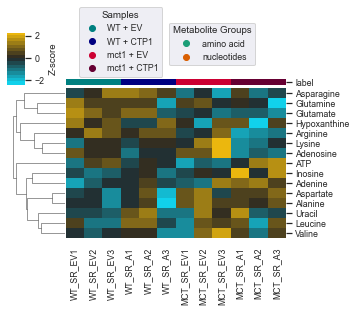

In [57]:
sns.set(font_scale=0.8)
sns.clustermap(
    metabolomics_ctp1Set[[
         'WT_SR_EV1',
         'WT_SR_EV2',
         'WT_SR_EV3',
         'WT_SR_A1',
         'WT_SR_A2',
         'WT_SR_A3',
         'MCT_SR_EV1',
         'MCT_SR_EV2',
         'MCT_SR_EV3',
         'MCT_SR_A1',
         'MCT_SR_A2',
         'MCT_SR_A3',
    ]].apply(pd.to_numeric),
    z_score=0,
    xticklabels=True,
    row_cluster=True,
    col_cluster=False,
    center=0,
    figsize=(5,4),
    cbar_kws={'label': 'Z-score'},
    col_colors=ctp1_colors1,
    cmap=jakes_cmap)

# Label legends
f = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [f("s", list(metabolite_hex.values())[i]) for i in range(len(list(metabolite_hex.values())))]
first_legend = plt.legend(handles, list(metabolite_hex.keys()), bbox_to_anchor=(9, 1.2), loc=2, borderaxespad=0., title='Metabolite Groups')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(ctp1_condition_hex.values())[i]) for i in range(len(list(ctp1_condition_hex.values())))]
plt.legend(handles_g, list(ctp1_condition_hex.keys()), bbox_to_anchor=(4, 1.5), loc=2, borderaxespad=0., title='Samples')


#Save and show figure
plt.savefig(
    os.path.join(plots_url, "aa_nt_list_ctp1_metabolomics.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

In [58]:
aa_nt_up = [
    'ATP',
    'Inosine',
    'Adenine',
    'Aspartate',
    'Alanine',
    'Uracil',
    'Leucine',
    'Valine'
]

metabolomics_ctp1Set_up = metabolomics_ctp1Set.copy()
metabolomics_ctp1Set_up = metabolomics_ctp1Set_up.loc[aa_nt_up]

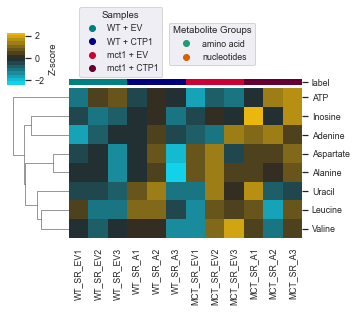

In [59]:
sns.set(font_scale=0.8)
sns.clustermap(
    metabolomics_ctp1Set_up[[
         'WT_SR_EV1',
         'WT_SR_EV2',
         'WT_SR_EV3',
         'WT_SR_A1',
         'WT_SR_A2',
         'WT_SR_A3',
         'MCT_SR_EV1',
         'MCT_SR_EV2',
         'MCT_SR_EV3',
         'MCT_SR_A1',
         'MCT_SR_A2',
         'MCT_SR_A3',
    ]].apply(pd.to_numeric),
    z_score=0,
    xticklabels=True,
    row_cluster=True,
    col_cluster=False,
    center=0,
    figsize=(5,4),
    cbar_kws={'label': 'Z-score'},
    col_colors=ctp1_colors1,
    cmap=jakes_cmap)

# Label legends
f = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [f("s", list(metabolite_hex.values())[i]) for i in range(len(list(metabolite_hex.values())))]
first_legend = plt.legend(handles, list(metabolite_hex.keys()), bbox_to_anchor=(9, 1.2), loc=2, borderaxespad=0., title='Metabolite Groups')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(ctp1_condition_hex.values())[i]) for i in range(len(list(ctp1_condition_hex.values())))]
plt.legend(handles_g, list(ctp1_condition_hex.keys()), bbox_to_anchor=(4, 1.5), loc=2, borderaxespad=0., title='Samples')

#Save and show figure
plt.savefig(
    os.path.join(plots_url, "ctp1_metabolomics_aa_nt_up.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

In [60]:
raff_set = ctp1_metabolomics[[

         'WT_SR_EV1',
         'WT_SR_EV2',
         'WT_SR_EV3',
         'WT_SR_A1',
         'WT_SR_A2',
         'WT_SR_A3',
         'MCT_SR_EV1',
         'MCT_SR_EV2',
         'MCT_SR_EV3',
         'MCT_SR_A1',
         'MCT_SR_A2',
         'MCT_SR_A3',
    ]]

raff_meta = ctp1_metadata.loc[[
         'WT_SR_EV1',
         'WT_SR_EV2',
         'WT_SR_EV3',
         'WT_SR_A1',
         'WT_SR_A2',
         'WT_SR_A3',
         'MCT_SR_EV1',
         'MCT_SR_EV2',
         'MCT_SR_EV3',
         'MCT_SR_A1',
         'MCT_SR_A2',
         'MCT_SR_A3',
    ]]
raff_meta['index'] = raff_meta.index.tolist()
raff_meta = raff_meta[['index', 'Condition']]
raff_meta.columns = [0,1]

<Figure size 432x288 with 0 Axes>

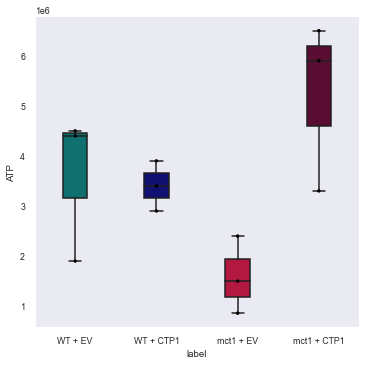

<Figure size 432x288 with 0 Axes>

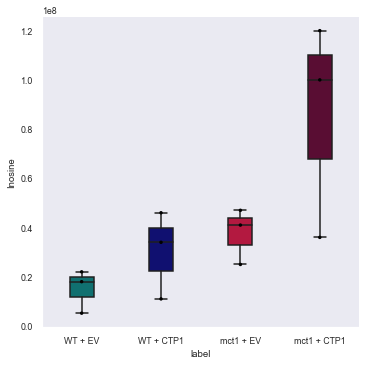

<Figure size 432x288 with 0 Axes>

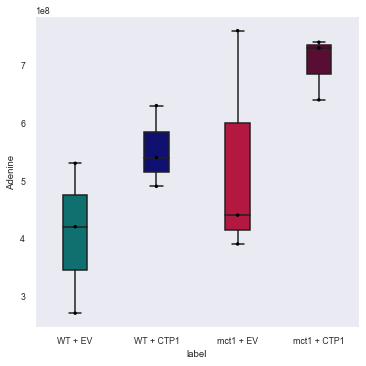

<Figure size 432x288 with 0 Axes>

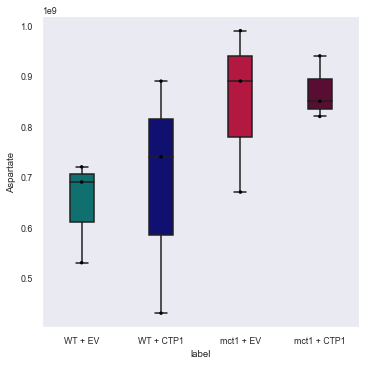

<Figure size 432x288 with 0 Axes>

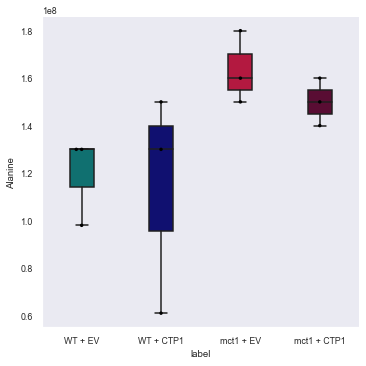

<Figure size 432x288 with 0 Axes>

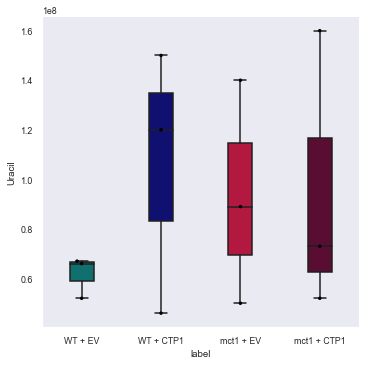

<Figure size 432x288 with 0 Axes>

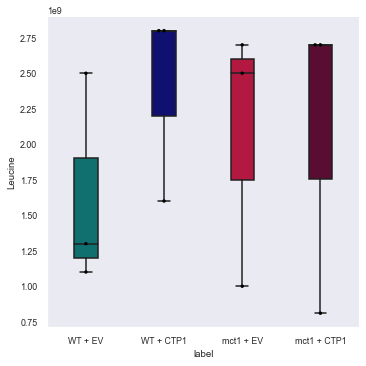

<Figure size 432x288 with 0 Axes>

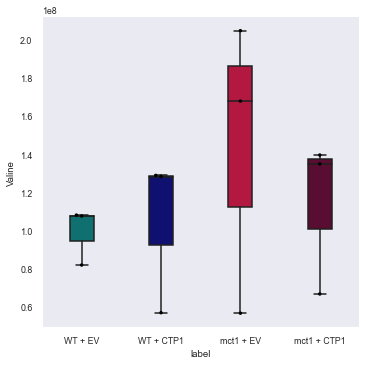

In [61]:
for x in aa_nt_up:

    xp.gene_overview(
        raff_set, 
        raff_meta, 
        gene_name=x, 
        palette=ctp1_condition_hex,
        order=['WT + EV','WT + CTP1','mct1 + EV', 'mct1 + CTP1'],
        save_fig=os.path.join(plots_url, "ctp1_metabolomics_boxplot_" + x + ".svg"),
        dpi=600
    )

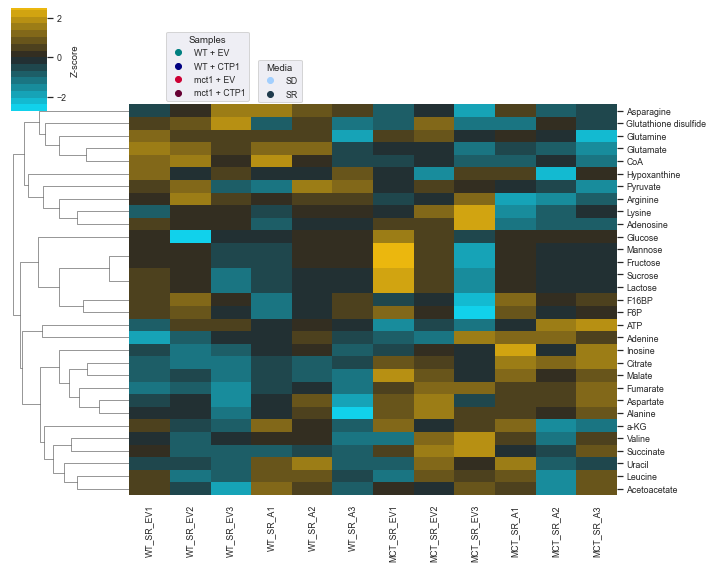

In [62]:
sns.set(font_scale=0.8)
sns.clustermap(
    ctp1_metabolomics[[
         'WT_SR_EV1',
         'WT_SR_EV2',
         'WT_SR_EV3',
         'WT_SR_A1',
         'WT_SR_A2',
         'WT_SR_A3',
         'MCT_SR_EV1',
         'MCT_SR_EV2',
         'MCT_SR_EV3',
         'MCT_SR_A1',
         'MCT_SR_A2',
         'MCT_SR_A3',
    ]].apply(pd.to_numeric),
    z_score=0,
    xticklabels=True,
    row_cluster=True,
    col_cluster=False,
    center=0,
    figsize=(10,8),
    cbar_kws={'label': 'Z-score'},
    
    cmap=jakes_cmap)

# Label legends

ff = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [ff("s", list(ctp1_media_hex.values())[i]) for i in range(len(list(ctp1_media_hex.values())))]
second_legend = plt.legend(handles, list(ctp1_media_hex.keys()), bbox_to_anchor=(6.85, 0.5), loc=2, borderaxespad=0., title='Media')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(second_legend)

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(ctp1_condition_hex.values())[i]) for i in range(len(list(ctp1_condition_hex.values())))]
plt.legend(handles_g, list(ctp1_condition_hex.keys()), bbox_to_anchor=(4.3, 0.77), loc=2, borderaxespad=0., title='Samples')


#Save and show figure
plt.savefig(
    os.path.join(plots_url, "all_ctp1_metabolomics.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

In [63]:
# Set labels and set color-codes for cols
ctp1_condition_hex = {
    'WT + EV':'#047495',
    'WT + CTP1':'#152238',
    'mct1 + EV':'#cc0033',
    'mct1 + CTP1':'#660033'}
ctp1_media_hex = {
    'SD':'#a2cffe',
    'SR':'#1f3b4d'}

ctp1_colors = ctp1_metadata.copy()

ctp1_colors['Condition'] = ctp1_colors['Condition'].map(ctp1_condition_hex)
ctp1_colors['Media'] = ctp1_colors['Media'].map(ctp1_media_hex)

ctp1_colors = ctp1_colors.loc[[
         'WT_SR_EV1',
         'WT_SR_EV2',
         'WT_SR_EV3',
         'WT_SR_A1',
         'WT_SR_A2',
         'WT_SR_A3',
         'MCT_SR_EV1',
         'MCT_SR_EV2',
         'MCT_SR_EV3',
         'MCT_SR_A1',
         'MCT_SR_A2',
         'MCT_SR_A3',
    ]]

ctp1_colors1 = ctp1_colors.copy()[['Condition']]
ctp1_colors1.columns = ['label']
ctp1_colors2 = ctp1_colors.copy()[['Media']]
ctp1_colors2.columns = ['label']

In [64]:
# Sort data by condition params
ctp1_metadata = ctp1_metadata.sort_values(["Condition", "Media"], ascending = (False, True))
metabolomics_ctp1Set = metabolomics_ctp1Set[ctp1_metadata.index.tolist()]

In [65]:
final_ctp1_metabolites = [
    'Glucose',
    'F6P', 
    'F16BP', 
    'Pyruvate',
    'CoA',
    'Citrate',
    'a-KG',
    'Glutamine',
    'Glutamate',
    'Succinate',
    'Fumarate',
    'Malate',
]
final_ctp1_metabolomics = ctp1_metabolomics.copy()
final_ctp1_metabolomics = final_ctp1_metabolomics.reindex(final_ctp1_metabolites, axis=0)

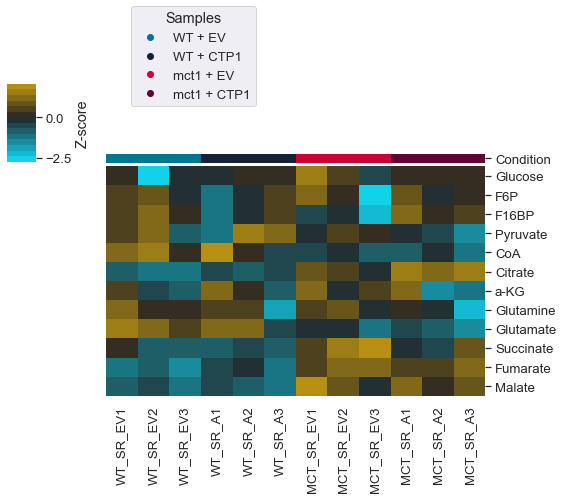

In [66]:
sns.set(font_scale=1.2)
sns.clustermap(
    final_ctp1_metabolomics[[
         'WT_SR_EV1',
         'WT_SR_EV2',
         'WT_SR_EV3',
         'WT_SR_A1',
         'WT_SR_A2',
         'WT_SR_A3',
         'MCT_SR_EV1',
         'MCT_SR_EV2',
         'MCT_SR_EV3',
         'MCT_SR_A1',
         'MCT_SR_A2',
         'MCT_SR_A3',
    ]].apply(pd.to_numeric),
    z_score=0,
    xticklabels=True,
    row_cluster=False,
    col_cluster=False,
    center=0,
    figsize=(8,6),
    cbar_kws={'label': 'Z-score'},
    col_colors=ctp1_colors['Condition'],
    cmap=jakes_cmap)

# Label legends

g = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles_g = [f("s", list(ctp1_condition_hex.values())[i]) for i in range(len(list(ctp1_condition_hex.values())))]
plt.legend(handles_g, list(ctp1_condition_hex.keys()), bbox_to_anchor=(4.3, 2), loc=2, borderaxespad=0., title='Samples')


#Save and show figure
plt.savefig(
    os.path.join(plots_url, "final_ctp1_metabolomics.svg"),
    dpi=600,
    bbox_inches='tight')
plt.show()

# CTP1 boxplots

In [67]:
final_metabolites = [
    'Glucose',
    'F6P', 
    'F16BP', 
    'Pyruvate',
    
    'CoA',
    'Citrate',
    'a-KG',
    'Glutamine',
    
    'Glutamate',
    'Succinate',
    'Fumarate',
    'Malate'   
]

biosyn = [
    'Adenine',
    'Alanine',
    'Arginine',
    'Asparagine ',
    
    'Aspartate',
    'ATP',
    'Inosine',
    'Leucine',
    
    'Uracil',
    'Valine'
]

alp = 'abcdefghijklmnopqrstuvwxyz'

In [68]:
from xpressplot import analysis_prep
%matplotlib inline

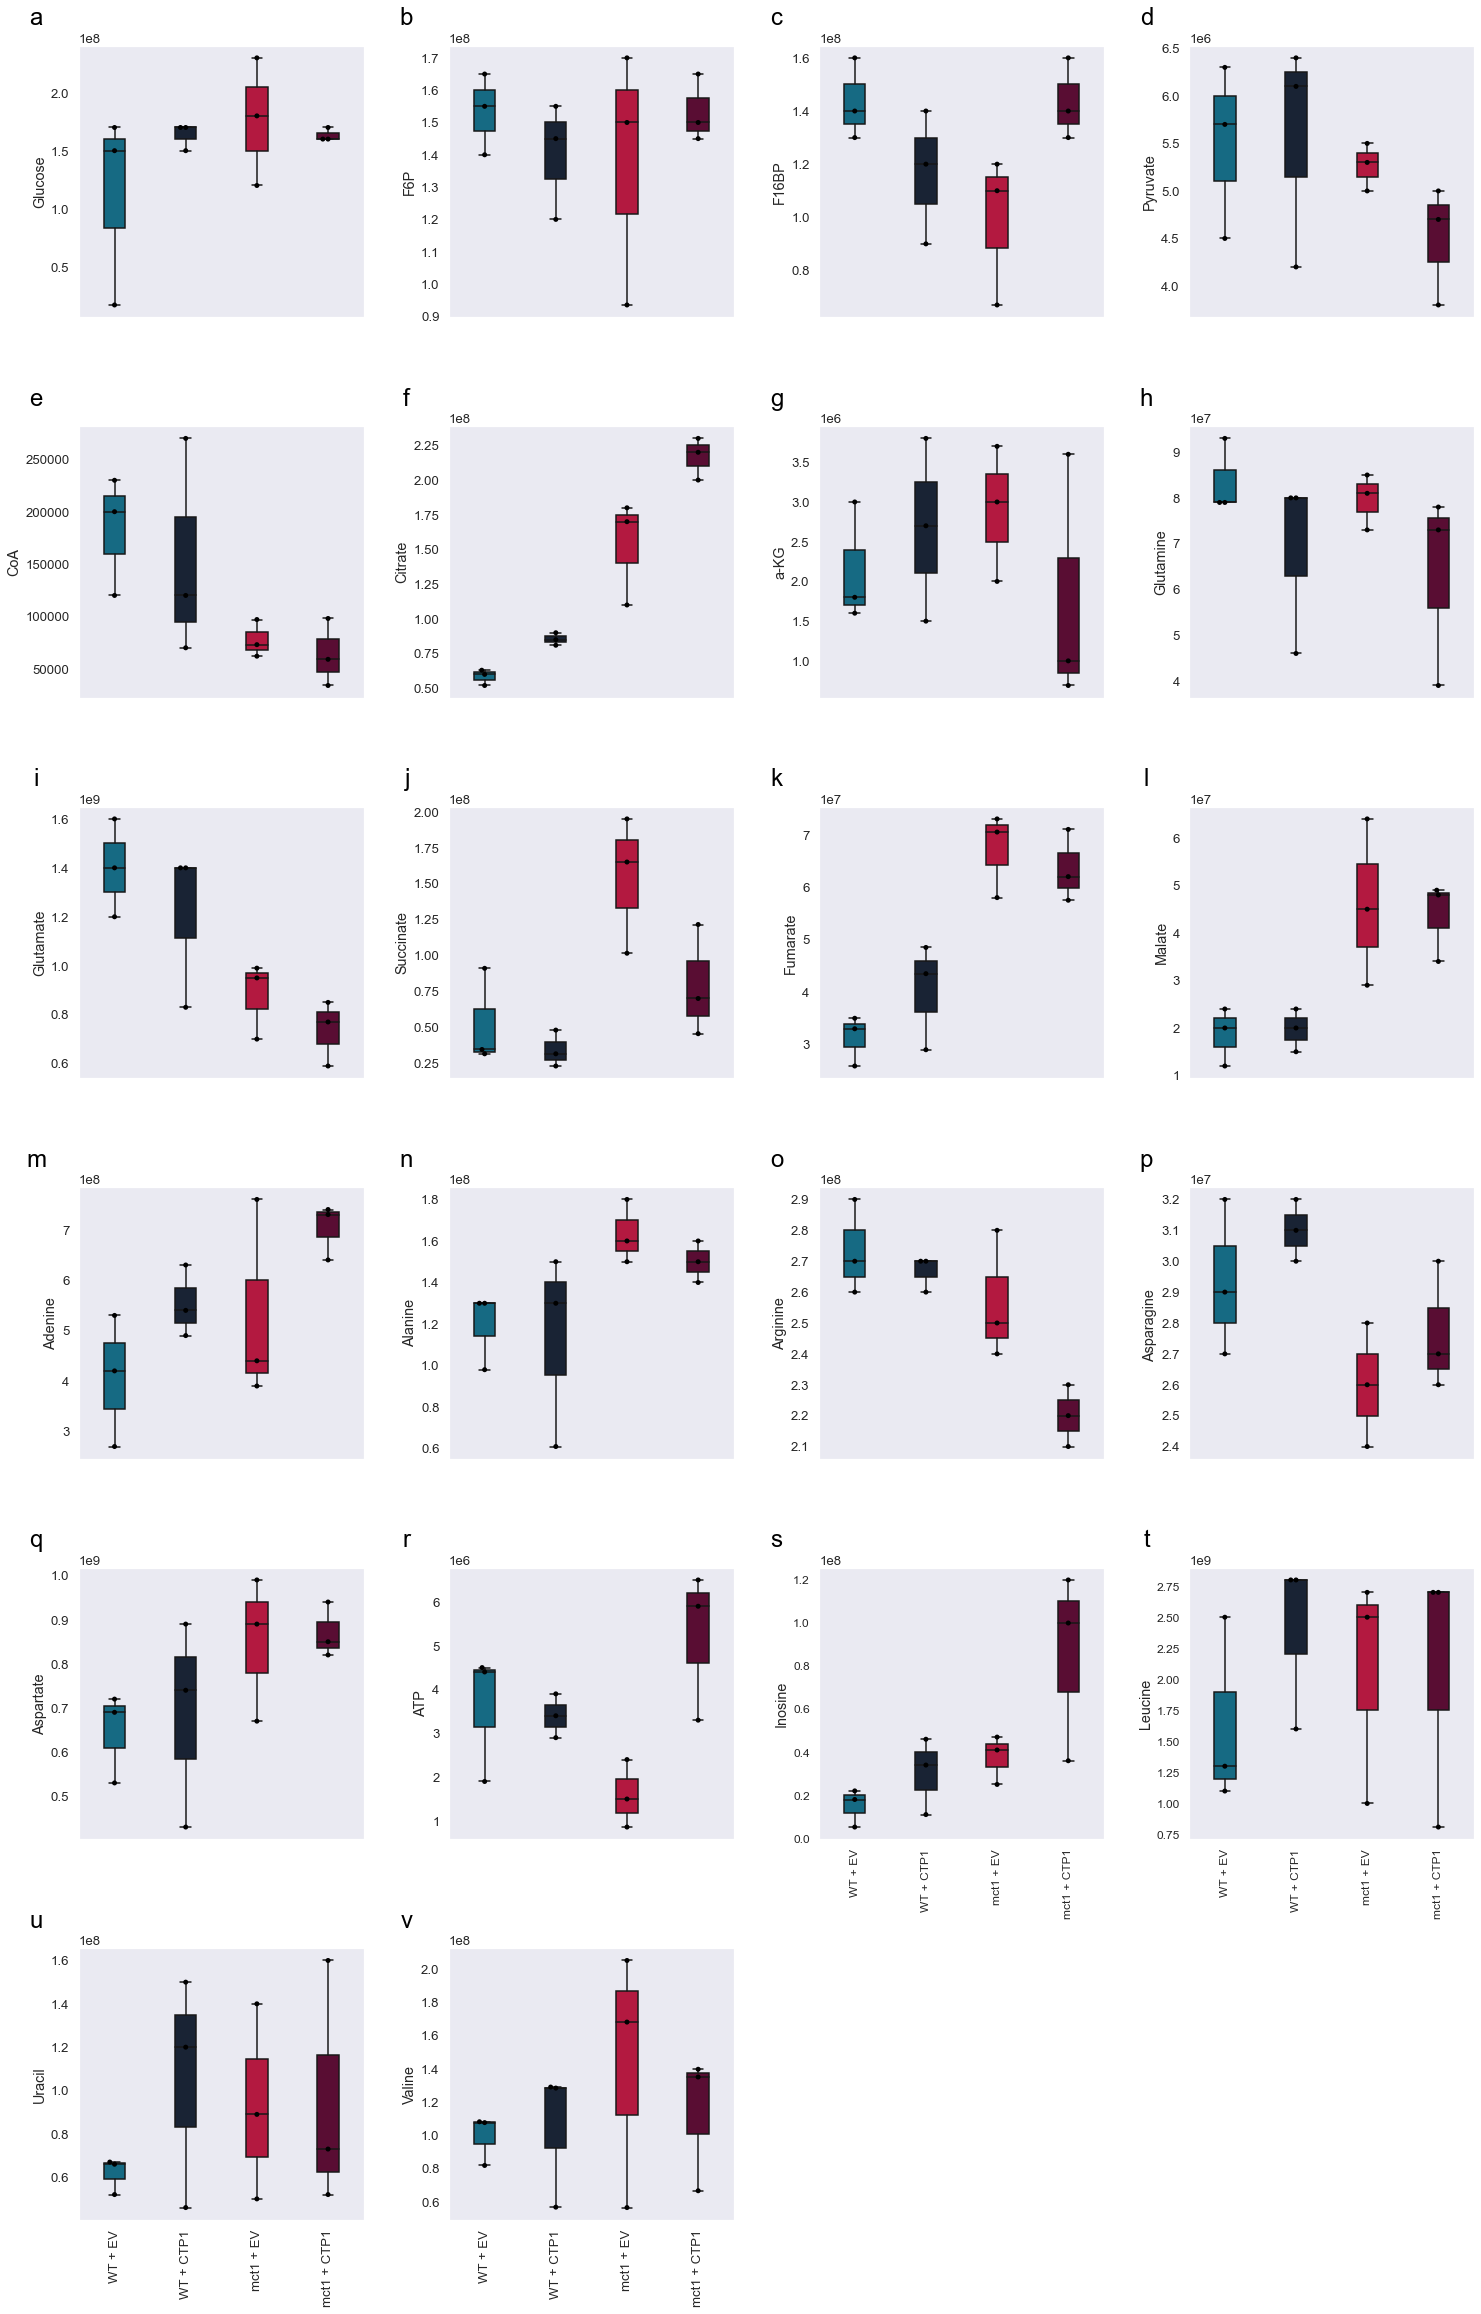

In [69]:
fig, axes = plt.subplots(6, 4, sharex=True, sharey=False, figsize=(25,40))
plt.subplots_adjust(wspace = 0.3, hspace = 0.4)
kw = dict(ha="center", va="center", fontsize=24, color="black")
sns.set_style("whitegrid")
data_c = analysis_prep(raff_set).T

# Prep data_scaled by adding labels from info to column (samples are rows)
labels = pd.Series(raff_meta[1].values,index=raff_meta[0]).to_dict()
data_c['label'] = data_c.index.to_series().map(labels)
    
x = 0
y = 0
tot = 0

for m in final_metabolites + biosyn:
    
    gene_df = data_c[[str(m), 'label']]
    gene_df[[str(m)]] = gene_df[[str(m)]].apply(pd.to_numeric, errors='coerce')
    
    # Swarm plot
    sns.swarmplot(
        x = 'label',
        y = str(m),
        data = gene_df,
        color = 'black',
        order=['WT + EV','WT + CTP1','mct1 + EV', 'mct1 + CTP1'],
        ax=axes[y, x])

    #Boxplot, fliersize=0 removes outlier diamonds from sns
    sns.boxplot(
        x = 'label',
        y = str(m),
        data = gene_df,
        width = 0.3,
        fliersize = 0,
        palette=ctp1_condition_hex,
        order=['WT + EV','WT + CTP1','mct1 + EV', 'mct1 + CTP1'],
        ax=axes[y, x])
    axes[y, x].set_xticklabels(axes[y, x].get_xticklabels(),rotation=90)
    axes[y, x].text(-0.15, 1.1, alp[tot], transform=axes[y, x].transAxes, **kw)
    axes[y, x].set_xlabel('')
    axes[y, x].grid(False)
    
    tot += 1
    x += 1
    if x >= 4:
        x = 0
        y += 1

axes[-1, -2].axis('off')
axes[-1, -1].axis('off')
axes[4,2].tick_params(axis='both', which='both', labelsize=kw['fontsize']/2, labelbottom=True)
axes[4,3].tick_params(axis='both', which='both', labelsize=kw['fontsize']/2, labelbottom=True)
        
plt.savefig(
    os.path.join(plots_url, "ctp1_metabolomics_boxplot_glycolysis-TCA-biosynthesis.svg"))
plt.show()

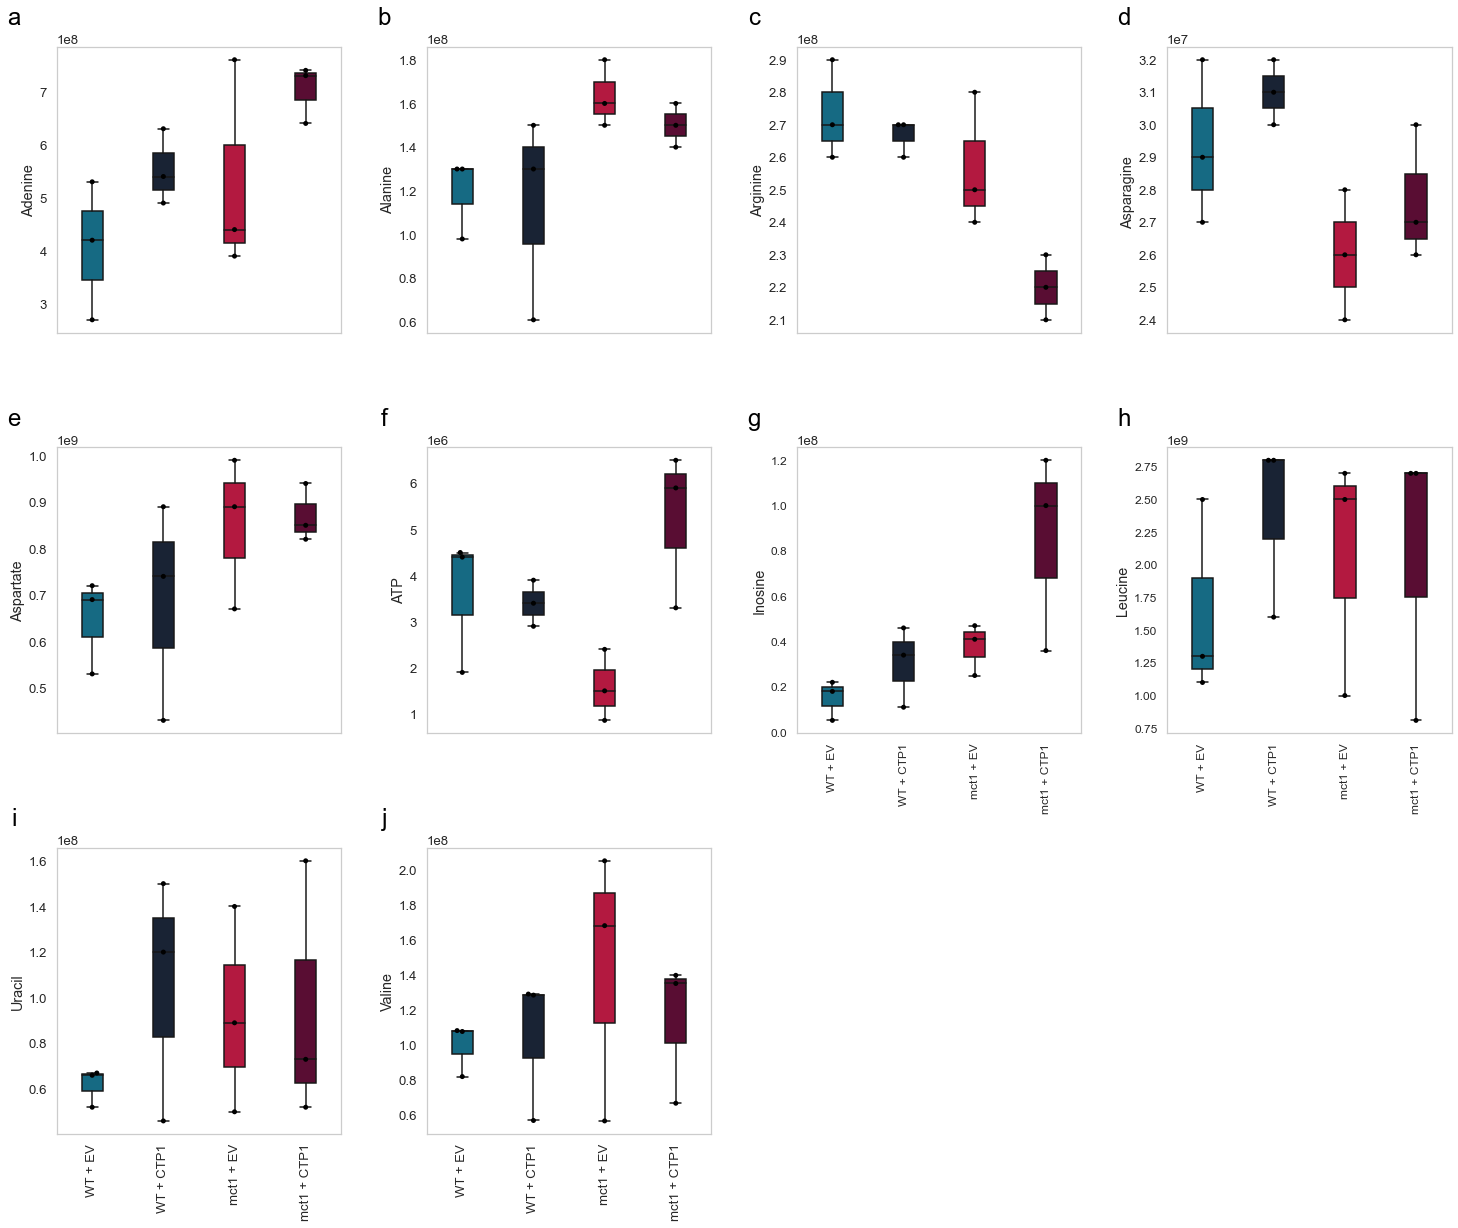

In [70]:
fig, axes = plt.subplots(3, 4, sharex=True, sharey=False, figsize=(25,20))
plt.subplots_adjust(wspace = 0.3, hspace = 0.4)
kw = dict(ha="center", va="center", fontsize=24, color="black")
sns.set_style("whitegrid")
data_c = analysis_prep(raff_set).T

# Prep data_scaled by adding labels from info to column (samples are rows)
labels = pd.Series(raff_meta[1].values,index=raff_meta[0]).to_dict()
data_c['label'] = data_c.index.to_series().map(labels)
    
x = 0
y = 0
tot = 0

alp = 'abcdefghijklmnop'

for m in biosyn:
    
    gene_df = data_c[[str(m), 'label']]
    gene_df[[str(m)]] = gene_df[[str(m)]].apply(pd.to_numeric, errors='coerce')
    
    # Swarm plot
    sns.swarmplot(
        x = 'label',
        y = str(m),
        data = gene_df,
        color = 'black',
        order=['WT + EV','WT + CTP1','mct1 + EV', 'mct1 + CTP1'],
        ax=axes[y, x])

    #Boxplot, fliersize=0 removes outlier diamonds from sns
    sns.boxplot(
        x = 'label',
        y = str(m),
        data = gene_df,
        width = 0.3,
        fliersize = 0,
        palette=ctp1_condition_hex,
        order=['WT + EV','WT + CTP1','mct1 + EV', 'mct1 + CTP1'],
        ax=axes[y, x])
    axes[y, x].set_xticklabels(axes[y, x].get_xticklabels(),rotation=90)
    axes[y, x].text(-0.15, 1.1, alp[tot], transform=axes[y, x].transAxes, **kw)
    axes[y, x].set_xlabel('')
    axes[y, x].grid(False)
    
    tot += 1
    x += 1
    if x >= 4:
        x = 0
        y += 1

axes[-1, -2].axis('off')
axes[-1, -1].axis('off')
axes[1,2].tick_params(axis='both', which='both', labelsize=kw['fontsize']/2, labelbottom=True)
axes[1,3].tick_params(axis='both', which='both', labelsize=kw['fontsize']/2, labelbottom=True)
plt.savefig(
    os.path.join(plots_url, "ctp1_metabolomics_boxplot_biosynthesis.svg"))